In [1]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            
    except RuntimeError as e:
        print(e)

from helpers import load_config

from sklearn.model_selection import train_test_split
import string   
import unicodedata
import numpy as np
import io
import os
from time import time

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [2]:
config = load_config("config.json")

# Downloading Data

Install the data using keras's `get_file` function

In [3]:
dataset_params = config["dataset"]
path_to_zip = tf.keras.utils.get_file(os.path.join(os.getcwd(), "datasets", "fra-eng.zip"), origin=dataset_params["url"], extract=True)
path_to_file = os.path.join(os.path.dirname(path_to_zip), "fra.txt")

# Dataset

For preprocessing, we will do the following:

- Clean the sentences from special characters.
- Add starting and ending tokens.
- Create a vocabulary.
- Pad each sentence to the maximum.
- Batch and prefetch.

In [4]:
def clean_sentence(sentence):
    # make a space between each punctionation
    sentence = sentence.translate(str.maketrans({key: " {0} ".format(key) for key in string.punctuation}))
    
    sentence = sentence.strip()  # remove spaces
    return sentence

def preprocess_a_sentence(sentence):
    # clean it
    sentence = clean_sentence(sentence)
    # add the start and end of sequences
    return '<sos> {} <eos>'.format(sentence)

def load_dataset(path, num_examples=None):
    with open(path, encoding='utf-8') as f:
        lines = f.read().strip().split("\n")
    # list containing a set of (input, output)
    sentence_pairs = [[preprocess_a_sentence(sen) for sen in line.split('\t')]  for line in lines[:num_examples]]
    return zip(*sentence_pairs)

In [5]:
en, fr = load_dataset(path_to_file)
print(en[3], fr[3])

<sos> Run ! <eos> <sos> Courez  ! <eos>


In [6]:
def get_tokenizer(lang):
    
    # we are keeping the punctionation
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='’,?!"#$%&()*+-/:;=.@[\\]^_`{|}~\t\n')
    tokenizer.fit_on_texts(lang)
    
    sequences = tokenizer.texts_to_sequences(lang)
    # pad the tensors
    sequences = tf.keras.preprocessing.sequence.pad_sequences(sequences, padding="post")
    return sequences, tokenizer

def create_dataset(X, y, batch_size=None, buffer=False, prefetch=tf.data.experimental.AUTOTUNE):
    a_set = tf.data.Dataset.from_tensor_slices((X, y))
    if buffer:
        a_set = a_set.shuffle(X.shape[0])
    if batch_size is not None:
        a_set = a_set.batch(batch_size, drop_remainder=True)
    return a_set.prefetch(prefetch)

def dataset(path, batch_size, num_examples=None, prefetch=tf.data.experimental.AUTOTUNE, test_size=0.2):
    target_lang, input_lang = load_dataset(path, num_examples=num_examples)
    
    input_sequences, input_tokenizer = get_tokenizer(input_lang)
    target_sequences, target_tokenizer = get_tokenizer(target_lang)
    
    input_train_seq, input_test_seq, target_train_seq, target_test_seq = train_test_split(input_sequences, 
                                                                                          target_sequences, 
                                                                                          test_size=test_size)
    
    train_set = create_dataset(input_train_seq, target_train_seq, 
                               batch_size=batch_size, buffer=True,
                               prefetch=prefetch)
    test_set = create_dataset(input_test_seq, target_test_seq, prefetch=prefetch)
    return train_set, test_set, input_train_seq.shape[0], input_tokenizer, target_tokenizer

In [7]:
batch_size = dataset_params["batch_size"]
num_examples = dataset_params["num_examples"]
train_set, test_set, train_size, input_tokenizer, target_tokenizer = dataset(path_to_file, batch_size, num_examples=num_examples)

In [8]:
for x, y, in train_set.take(1):
    i = 8
    print(input_tokenizer.sequences_to_texts([x[i].numpy()]))
    print(target_tokenizer.sequences_to_texts([y[i].numpy()]))

['<sos> je suis soûl <eos>']
["<sos> i ' m drunk <eos>"]


# Build Model

In [9]:
from model import Encoder, Decoder

## Set params

In [10]:
model_params = config["model"]

epochs = model_params["epochs"]
embedding_dim = model_params["embedding_dim"]
units = model_params["units"]
bidirectional = model_params["bidirectional"]

steps_per_epoch = train_size // batch_size
input_vocab_size = len(input_tokenizer.word_index) + 1
target_vocab_size = len(target_tokenizer.word_index) + 1

In [11]:
encoder = Encoder(input_vocab_size, embedding_dim, units, bidirectional=bidirectional)
decoder = Decoder(target_vocab_size, embedding_dim, units, bidirectional=bidirectional)

## Compile Model

In [12]:
optimizer = tf.keras.optimizers.Nadam()

loss_object = tf.keras.losses.SparseCategoricalCrossentropy()

train_loss = tf.keras.metrics.Mean(name='train_loss')

def loss_function(real, pred):
    # set mask True to everywhere but zero (zero is the padding)
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

# Training

The training's steps are:

1. Pass the input through the encoder and get the encoder's outputs and the states.

2. The encoder output and hidden states and the decoder state's is passed to the decoder.

3. We feed the encoder's input, state and token to decoder:
    - The decoder will spit the output and hidden state
    - The decoder hidden state is then passed back into the model and the predictions are used to calculate the loss.
    - Use Teacher Forcing to decide the next input to the decoder.
    - Repeat for each time step in the decoder's input.
4. The final step is to calculate the gradients and apply it to the optimizer and backpropagation

In [13]:
@tf.function
def train_step(X, y):
    loss = 0
    batch_size = X.shape[0]
    
    with tf.GradientTape() as tape:
        enc_output, enc_hidden = encoder(X)
        
        dec_hidden = enc_hidden
        # target input at the begining should only be <start>
        dec_input = tf.expand_dims([target_tokenizer.word_index['<sos>']] * batch_size, 1)
        
        for t in range(1, y.shape[1]): # starting from 1 as we created the <start> above.
            predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
            
            loss += loss_function(y[:, t], predictions)  # compute the loss based on the predictions
            
            # using teacher forcing
            dec_input = tf.expand_dims(y[:, t], 1)  # here we give the actual target and not the predictions as input.
        
    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    return loss

In [14]:
def progress_bar(iteration, total, size=30):
    running = iteration < total
    c = ">" if running else "="
    p = (size - 1) * iteration // total
    fmt = "{{:-{}d}}/{{}} [{{}}]".format(len(str(total)))
    params = [iteration, total, "=" * p + c + "." * (size - p - 1)]
    return fmt.format(*params)

def print_status_bar(iteration, total, loss, metrics=None, size=30):
    metrics = " - ".join(["{}: {:.4f}".format(m.name, m.result())
                         for m in [loss] + (metrics or [])])
    end = "" if iteration < total else "\n"
    print("\r{} - {}".format(progress_bar(iteration, total), metrics), end=end)

In [ ]:
for epoch in range(epochs):
    
    start = time()
    
    for (step, (X, y)) in enumerate(train_set.take(steps_per_epoch)):
        loss = train_step(X, y)  # for each epoch, step, we are reseting the states (it is not stateful)
        train_loss(loss)
        
        print_status_bar(step * batch_size, train_size, train_loss, None)
        
    print_status_bar(train_size, train_size, train_loss, None)
    print('Time taken for 1 epoch {} sec\n'.format(time() - start))

# Evaluation

To evaluate and chek the performance of the model, we will do the following:

- Write evaluation function for the test data (similar to training loop but without teacher forcing.
- Stop predicting when the model predicts the end token
- Store the attention weights fore very time step for visualization.

In [44]:
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
   
    plt.show()


def evaluate(inputs, max_target_pad):
    
    attention_plot = np.zeros((max_target_pad, inputs.shape[0]))
    
    # convert from words to sequence
    
    result = []
    
    # running the encoder
    enc_output, dec_hidden = encoder(tf.expand_dims(inputs, 0))
    
    dec_input = tf.expand_dims([target_tokenizer.word_index['<sos>']], 0)
    
    for t in range(max_target_pad):
        predictions, dec_hidden, attention_weights = decoder(dec_input, dec_hidden, enc_output)
        
        # storing the attention weights to plot later on
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()
        
        predicted_id = tf.argmax(predictions[0]).numpy()
        predicted_word = target_tokenizer.index_word[predicted_id]
        if predicted_word  == '<eos>':
            return " ".join(result), attention_plot
        
        result.append(predicted_word)
        
        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)
        
    return " ".join(result), attention_plot


def translate(X, y):
    sentence = input_tokenizer.sequences_to_texts([X.numpy()])[0]
    translation = target_tokenizer.sequences_to_texts([y.numpy()])[0]
    result, attention_plot = evaluate(X, y.shape[0])

    print('Input: %s' % (sentence))
    print('Actual translation: %s' % (translation))
    print('Predicted translation: %s '% (result))

    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))

Input: <sos> c est triste <eos>
Actual translation: <sos> it ' s sad <eos>
Predicted translation: i ' m fair 


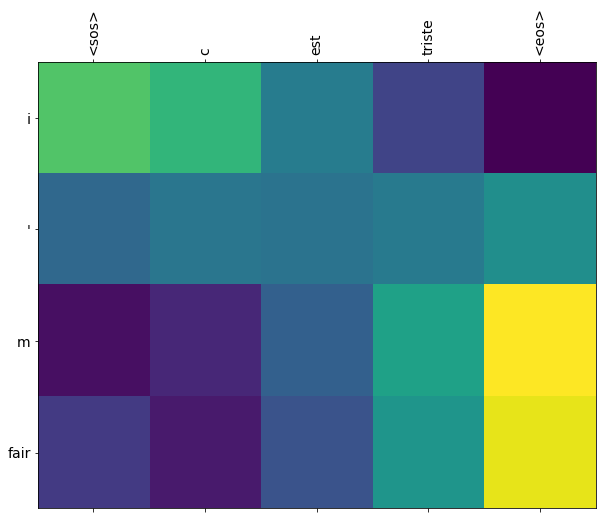

In [45]:
for X, y in test_set.take(1):
    translate(X, y)

# References and Further Readings

- [Neural Machine Translation by Jointly Learning to Align and Translate](https://arxiv.org/abs/1409.0473)
- [Neural Machine Translation with Attention](https://www.tensorflow.org/tutorials/text/nmt_with_attention)
- [Hands-on Machine Learning With Scikit-Learn, Keras & Tensorflow](https://github.com/ageron/handson-ml2)